In [2]:
import numpy as np
import astropy.io.fits as pf
import piff
import matplotlib.pyplot as plt
import matplotlib.colors as color
import galsim
import logging
import pandas
import os
import ngmix
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Table, hstack
%matplotlib inline

In [3]:
direc = '/Users/rebeccachen/Desktop/Piff_work/'

ID = '00241238'
chip = '28'
indir = '/Users/rebeccachen/Desktop/Piff_work/y1_test/'
image = 'DECam_'+str(ID)+'_'+str(chip)+'.fits.fz'
cat = 'DECam_'+str(ID)+'_'+str(chip)+'_cat.fits'
bkg = 'DECam_'+str(ID)+'_'+str(chip)+'_bkg.fits.fz'
findstar = 'DECam_'+str(ID)+'_'+str(chip)+'_findstars.fits'
psfcat = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.psf'
psfcat_used = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.used.fits'
psfcat_xml = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat.xml'
psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'

piffdir = '/Users/rebeccachen/Piff/examples/'

In [4]:
gaia1 = pf.open(direc+'gaia_000001.fits')[1].data
gaia2 = pf.open(direc+'gaia_000002.fits')[1].data
gaia3 = pf.open(direc+'gaia_000002.fits')[1].data

FileNotFoundError: [Errno 2] No such file or directory: '/Users/rebeccachen/Desktop/Piff_work/gaia_000001.fits'

In [ ]:
t1 = Table.read('gaia_000001.fits', format='fits')
t2 = Table.read('gaia_000002.fits', format='fits')
t3 = Table.read('gaia_000003.fits', format='fits')
onetwo = hstack([t1, t2])
new = hstack([onetwo, t3])
new.write('combined_gaia.fits')

In [ ]:
combined_gaia = pf.open(direc+'combined_gaia.fits')
type(combined_gaia)

In [109]:
combined_gaia.info()

Filename: /Users/rebeccachen/Desktop/Piff_work/combined_gaia.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    215   5220000R x 81C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, J, J, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, J, J, K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, J, J]   


In [110]:
combined_gaia[1].data.columns

ColDefs(
    name = 'COADD_OBJECT_ID_1'; format = 'K'; null = 999999
    name = 'RA_1'; format = 'D'
    name = 'DEC_1'; format = 'D'
    name = 'FLUX_RADIUS_G_1'; format = 'D'
    name = 'FLUX_RADIUS_R_1'; format = 'D'
    name = 'FLUX_RADIUS_I_1'; format = 'D'
    name = 'SPREAD_MODEL_I_1'; format = 'D'
    name = 'SPREADERR_MODEL_I_1'; format = 'D'
    name = 'WAVG_SPREAD_MODEL_I_1'; format = 'D'
    name = 'WAVG_SPREADERR_MODEL_I_1'; format = 'D'
    name = 'MOF_CM_T_1'; format = 'D'
    name = 'MOF_CM_T_ERR_1'; format = 'D'
    name = 'MAG_PSF_I_1'; format = 'D'
    name = 'MAG_AUTO_I_1'; format = 'D'
    name = 'MAGERR_AUTO_I_1'; format = 'D'
    name = 'MAG_AUTO_R_1'; format = 'D'
    name = 'MAGERR_AUTO_R_1'; format = 'D'
    name = 'MAG_AUTO_G_1'; format = 'D'
    name = 'MAGERR_AUTO_G_1'; format = 'D'
    name = 'MOF_PSF_MAG_I_1'; format = 'D'
    name = 'MOF_PSF_MAG_ERR_I_1'; format = 'D'
    name = 'MOF_CM_MAG_I_1'; format = 'D'
    name = 'MOF_CM_MAG_ERR_I_1'; format = 'D'

In [41]:
gaia1_coord = SkyCoord(gaia1['RA']*u.deg, gaia1['DEC']*u.deg)
gaia2_coord = SkyCoord(gaia2['RA']*u.deg, gaia2['DEC']*u.deg)
gaia3_coord = SkyCoord(gaia3['RA']*u.deg, gaia3['DEC']*u.deg)

In [42]:
print(gaia2_coord, gaia3_coord)

<SkyCoord (ICRS): (ra, dec) in deg
    [(320.492851,  1.760678), (320.391773,  1.759961),
     (320.597563,  1.76026 ), ..., ( 42.585941, -1.684823),
     ( 42.903574, -1.691   ), ( 42.982536, -1.598847)]> <SkyCoord (ICRS): (ra, dec) in deg
    [(320.492851,  1.760678), (320.391773,  1.759961),
     (320.597563,  1.76026 ), ..., ( 42.585941, -1.684823),
     ( 42.903574, -1.691   ), ( 42.982536, -1.598847)]>


In [43]:
matches = []
matches2 = []
matches3 = []

frac_stars = []

for i in [x for x in range(1, 63) if (x != 31 and x!= 61)]:
# for i in range(1,10):
    des_indices = []
    chip = "%.2d" % i
    psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'
    des = pf.open(indir+psfcat_cut)[2].data
    des_coord = SkyCoord(des['ALPHAWIN_J2000']*u.deg, des['DELTAWIN_J2000']*u.deg)
#     print(len(des_coord))
    idx_des, idx_gaia, d2d, d3d = SkyCoord.search_around_sky(gaia1_coord, des_coord, .0003*u.deg)
    idx_des2, idx_gaia2, d2d2, d3d2 = SkyCoord.search_around_sky(gaia2_coord, des_coord, .0003*u.deg)
    idx_des3, idx_gaia3, d2d3, d3d3 = SkyCoord.search_around_sky(gaia3_coord, des_coord, .0003*u.deg)
    des_indices.extend(idx_des)
    des_indices.extend(idx_des2)
    des_indices.extend(idx_des3)
    des_sliced = des[des_indices]
    new_hdu = pf.BinTableHDU.from_columns(des_sliced._get_raw_data())
#     new_hdu.writeto(indir+'gaiamatch_DECam_'+str(ID)+'_'+str(chip)+'.fits')
#     print(des['ALPHAWIN_J2000'][idx_des])
#     print(gaia1['RA'][idx_gaia])
#     print(des['DELTAWIN_J2000'][idx_des])
#     print(gaia1['DEC'][idx_gaia])
    print('chip: '+str(chip)+', stars in psfcat_cut: '+ str(len(des.data))+ ', stars in matched: ' + str(len(des_sliced)))
#     print(idx_gaia)
#     print(len(idx_gaia))
    frac_stars.append(len(des_sliced)/len(des.data))
    matches.extend(idx_gaia)
    matches2.extend(idx_gaia2)
    matches3.extend(idx_gaia3)

chip: 01, stars in psfcat_cut: 117, stars in matched: 52
chip: 02, stars in psfcat_cut: 100, stars in matched: 48
chip: 03, stars in psfcat_cut: 121, stars in matched: 85
chip: 04, stars in psfcat_cut: 108, stars in matched: 22
chip: 05, stars in psfcat_cut: 122, stars in matched: 58
chip: 06, stars in psfcat_cut: 124, stars in matched: 74
chip: 07, stars in psfcat_cut: 98, stars in matched: 31
chip: 08, stars in psfcat_cut: 122, stars in matched: 80
chip: 09, stars in psfcat_cut: 116, stars in matched: 80
chip: 10, stars in psfcat_cut: 87, stars in matched: 20
chip: 11, stars in psfcat_cut: 133, stars in matched: 56
chip: 12, stars in psfcat_cut: 119, stars in matched: 47
chip: 13, stars in psfcat_cut: 95, stars in matched: 70
chip: 14, stars in psfcat_cut: 114, stars in matched: 48
chip: 15, stars in psfcat_cut: 94, stars in matched: 58
chip: 16, stars in psfcat_cut: 115, stars in matched: 86
chip: 17, stars in psfcat_cut: 128, stars in matched: 26
chip: 18, stars in psfcat_cut: 119,

In [28]:
# Centers of chips in focal plane coordinates
N7=["N7",16.908,191.670]
N6=["N6",16.908,127.780]
N5=["N5",16.908,63.890]
N4=["N4",16.908,0.]
N3=["N3",16.908,-63.890]
N2=["N2",16.908,-127.780]
N1=["N1",16.908,-191.670]

N13=["N13",50.724,159.725]
N12=["N12",50.724,95.835]
N11=["N11",50.724,31.945]
N10=["N10",50.724,-31.945]
N9=["N9",50.724,-95.835]
N8=["N8",50.724,-159.725]

N19=["N19",84.540,159.725]
N18=["N18",84.540,95.835]
N17=["N17",84.540,31.945]
N16=["N16",84.540,-31.945]
N15=["N15",84.540,-95.835]
N14=["N14",84.540,-159.725]

N24=["N24",118.356,127.780]
N23=["N23",118.356,63.890]
N22=["N22",118.356,0.]
N21=["N21",118.356,-63.890]
N20=["N20",118.356,-127.780]

N28=["N28",152.172,95.835]
N27=["N27",152.172,31.945]
N26=["N26",152.172,-31.945]
N25=["N25",152.172,-95.835]

N31=["N31",185.988,63.890]
N30=["N30",185.988,0.]
N29=["N29",185.988,-63.890]

S7=["S7",-16.908,191.670]
S6=["S6",-16.908,127.780]
S5=["S5",-16.908,63.890]
S4=["S4",-16.908,0.]
S3=["S3",-16.908,-63.890]
S2=["S2",-16.908,-127.780]
S1=["S1",-16.908,-191.670]

S13=["S13",-50.724,159.725]
S12=["S12",-50.724,95.835]
S11=["S11",-50.724,31.945]
S10=["S10",-50.724,-31.945]
S9=["S9",-50.724,-95.835]
S8=["S8",-50.724,-159.725]

S19=["S19",-84.540,159.725]
S18=["S18",-84.540,95.835]
S17=["S17",-84.540,31.945]
S16=["S16",-84.540,-31.945]
S15=["S15",-84.540,-95.835]
S14=["S14",-84.540,-159.725]

S24=["S24",-118.356,127.780]
S23=["S23",-118.356,63.890]
S22=["S22",-118.356,0.]
S21=["S21",-118.356,-63.890]
S20=["S20",-118.356,-127.780]

S28=["S28",-152.172,95.835]
S27=["S27",-152.172,31.945]
S26=["S26",-152.172,-31.945]
S25=["S25",-152.172,-95.835]

S31=["S31",-185.988,63.890]
S30=["S30",-185.988,0.]
S29=["S29",-185.988,-63.890]

# order of chips when using numeric label
ccdid = [S29,S30,S31,S25,S26,S27,S28,S20,S21,S22,S23,S24,S14,S15,S16,S17,S18,S19,S8,S9,S10,S11,S12,S13,S1,S2,S3,S4,S5,S6,S7,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,N15,N16,N17,N18,N19,N20,N21,N22,N23,N24,N25,N26,N27,N28,N29,N30,N31]

# defines the size of a chip in mm.  One pixel=15 microns
xsize=2048*15e-6*1000
ysize=4096*15e-6*1000

# xc, yc are the (x,y) position of the lower left corner of each chip
xc = np.empty(len(ccdid)+1)
yc = np.empty(len(ccdid)+1)
for i,ext in enumerate(ccdid):
    xc[i+1] = ext[1]-xsize/2
    yc[i+1] = ext[2]-ysize/2

def toFocal(ccd,x,y):
    return x*15e-6*1000+xc[ccd],y*15e-6*1000+yc[ccd]

In [30]:
chip_x = []
chip_y = []
for i in range(len(ccdid)):
    chip_x.append(xc[i])
    chip_y.append(yc[i])
    chip_x.append(xc[i]+xsize)
    chip_y.append(yc[i])
    chip_x.append(xc[i]+xsize)
    chip_y.append(yc[i]+ysize)
    chip_x.append(xc[i])
    chip_y.append(yc[i]+ysize)

In [52]:
colors = color.Colormap(frac_stars)
print(colors)

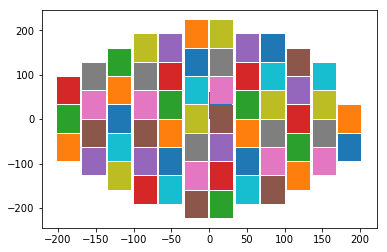

In [54]:
plt.figure()
for i in range(len(chip_x))[::4]:
    xs = []
    ys = []
    xs.append(chip_x[i])
    ys.append(chip_y[i])
    xs.append(chip_x[i+1])
    ys.append(chip_y[i+1])
    xs.append(chip_x[i+2])
    ys.append(chip_y[i+2])
    xs.append(chip_x[i+3])
    ys.append(chip_y[i+3])
    plt.fill(xs, ys)
# plt.colorbar(c)
plt.show()

In [64]:
print(frac_stars)

[0.4444444444444444, 0.48, 0.7024793388429752, 0.2037037037037037, 0.47540983606557374, 0.5967741935483871, 0.3163265306122449, 0.6557377049180327, 0.6896551724137931, 0.22988505747126436, 0.42105263157894735, 0.3949579831932773, 0.7368421052631579, 0.42105263157894735, 0.6170212765957447, 0.7478260869565218, 0.203125, 0.4789915966386555, 0.44, 0.7131782945736435, 0.7272727272727273, 0.494949494949495, 0.33884297520661155, 0.22826086956521738, 0.5977011494252874, 0.5045045045045045, 0.6956521739130435, 0.7264150943396226, 0.3611111111111111, 0.2727272727272727, 1.0101010101010102, 0.7628865979381443, 0.509090909090909, 0.40350877192982454, 0.4329896907216495, 0.2604166666666667, 0.325, 0.6019417475728155, 0.7092198581560284, 0.6766917293233082, 0.25, 0.376, 0.225, 0.4421052631578947, 0.9009009009009009, 0.5697674418604651, 0.2818181818181818, 0.5181818181818182, 0.42045454545454547, 0.6538461538461539, 0.6862745098039216, 0.2222222222222222, 0.37168141592920356, 0.4166666666666667, 0.4

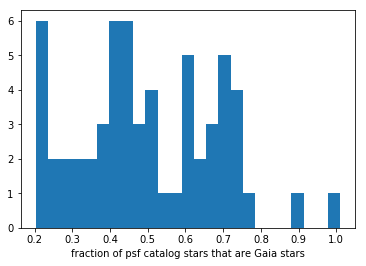

In [68]:
plt.figure()
plt.xlabel('fraction of psf catalog stars that are Gaia stars')
plt.hist(frac_stars, bins=25)
plt.show()

In [34]:
print(matches2)
print(matches3)
print(len(matches), len(matches2), len(matches3))
print(len(np.unique(matches)))

[1412990, 1413001, 1520935, 1520999, 1519258, 1520958, 1520962, 1521025, 1519260, 1521013, 1520969, 1520914, 1521044, 1520981, 1519235, 1519241, 1521030, 1521028, 1521024, 1520987, 1520919, 1521057, 1521012, 1522052, 1520903, 1520920, 1520921, 1520996, 1519240, 1520900, 1520965, 1521036, 1521055, 1521027, 1519245, 1520910, 1520929, 1521043, 1521039, 1521042, 1520904, 1520993, 1521001, 1521019, 1520986, 1519250, 1521015, 1519264, 1520984, 1521007, 1522053, 1520938, 1520939, 1521018, 1520953, 1522059, 1519229, 1520931, 1520995, 1521041, 1519252, 1520922, 1521016, 1521017, 1520927, 1520972, 1521059, 1521029, 1520913, 1520933, 1521053, 1519237, 1520942, 1520992, 1520943, 1519238, 1520915, 1520902, 1519234, 1520975, 1691965, 1691985, 1691978, 1691973, 1691974, 1691912, 1691994, 1691964, 1691997, 1691992, 1691975, 1691989, 1413043, 1435125, 1435115, 1413063, 1434138, 1435134, 1413030, 1413026, 1751510, 1751565, 1754444, 1751656, 1751514, 1751645, 1751575, 1751621, 1751626, 1751616, 1754439, 

In [13]:
# matches = []

# # for i in [x for x in range(1, 63) if (x != 31 and x!= 61)]:
# for i in range(1,3):

#     chip = "%.2d" % i
#     psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'
#     des = pf.open(indir+psfcat_cut)[2].data
#     des_coord = SkyCoord(des['ALPHAWIN_J2000']*u.deg, des['DELTAWIN_J2000']*u.deg)
#     print(len(des_coord))
#     idx_gaia, d2d_gaia, d3d_gaia = des_coord.match_to_catalog_sky(gaia1_coord)
#     print(idx_gaia)
#     print(len(idx_gaia))
#     matches.extend(idx_gaia)


In [29]:
sing_matches = np.unique(matches)
print(len(sing_matches))

975


In [93]:
# idx_gaia, d2d_gaia, d3d_gaia = des_coord.match_to_catalog_sky(gaia1_coord)

In [27]:
print(len(gaia1_coord))
print(len(des_coord))
print(len(gaia1_coord[idx_gaia]))

5220000
119
52


In [1]:
plt.figure(figsize=(10,10))
plt.xlim((13, 23))
plt.ylim((0, 10))
mag_gaia = gaia1['MAG_AUTO_R']
radius_gaia = gaia1['FLUX_RADIUS_R']
mag_gaia2 = gaia2['MAG_AUTO_R']
radius_gaia2 = gaia2['FLUX_RADIUS_R']
mag_gaia3 = gaia3['MAG_AUTO_R']
radius_gaia3 = gaia3['FLUX_RADIUS_R']
plt.scatter(mag_gaia, radius_gaia, marker='x', alpha=0.3, c='r')
plt.scatter(mag_gaia2, radius_gaia2, marker='x', alpha=0.3, c='r')
plt.scatter(mag_gaia3, radius_gaia3, marker='x', alpha=0.3, c='r')
for i in [x for x in range(1, 63) if (x != 31 and x!= 61)]:
    chip = "%.2d" % i
    psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'
    image = 'DECam_'+str(ID)+'_'+str(chip)+'.fits.fz'
    pf.open(indir+image)[1].header['FILTER']
    
    mag = pf.open(indir+psfcat_cut)[2].data['MAG_AUTO']
    radius = pf.open(indir+psfcat_cut)[2].data['FLUX_RADIUS']
    plt.scatter(mag, radius, marker='x', alpha=0.3, c='b')

matches_mag = gaia1['MAG_AUTO_R'][sing_matches] 
matches_radius = gaia1['FLUX_RADIUS_R'][sing_matches] 
matches_mag2 = gaia2['MAG_AUTO_R'][matches2] 
matches_radius2 = gaia2['FLUX_RADIUS_R'][matches2] 
plt.scatter(matches_mag, matches_radius, marker='x', c='black')
plt.scatter(matches_mag2, matches_radius2, marker='x', c='black')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
ra = gaia1['RA'][sing_matches][:10]
print(ra)
ra2 = des

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([15.        , 15.03333333, 15.06666667, 15.1       , 15.13333333,
        15.16666667, 15.2       , 15.23333333, 15.26666667, 15.3       ,
        15.33333333, 15.36666667, 15.4       , 15.43333333, 15.46666667,
        15.5       , 15.53333333, 15.56666667, 15.6       , 15.63333333,
        15.66666667, 15.7       , 15.73333333, 15.76666667, 15.8       ,
        15.83333333, 15.86666667, 15.9       , 15.93333333, 15.96666667,
        16.        , 16.03333333, 16.06666667, 16.1       , 16.13333333,
        16.16666667, 16.2       , 16.23333333, 16.26666667, 16.3       ,
        16.33333333, 16.36666667, 16.4       , 16.43333333, 16.46666667,
        16.5       , 16.53333333, 16.56666667, 16.6       , 16.63333333,
        16.66666667, 

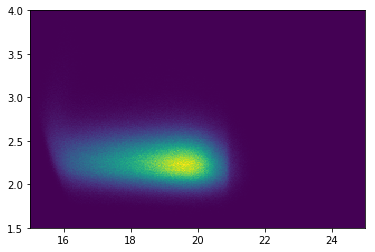

In [138]:
plt.figure()
plt.hist2d(mag_gaia, radius_gaia, range=((15,25),(1.5,4)), bins=300)

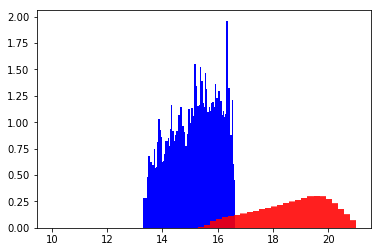

In [136]:
plt.figure()
for i in [x for x in range(1, 63) if (x != 31 and x!= 61)]:
    chip = "%.2d" % i
    psfcat_cut = 'DECam_'+str(ID)+'_'+str(chip)+'_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits'
    
    mag = pf.open(indir+psfcat_cut)[2].data['MAG_AUTO']
    plt.hist(mag, bins = 50, color='b', normed=True)
    
plt.hist(mag_gaia, bins = 50, color = 'r', alpha=0.5, range=(10, 21), normed=True)
plt.hist(mag_gaia2, bins = 50, color = 'r', alpha=0.5, range=(10, 21), normed=True)
plt.hist(mag_gaia3, bins = 50, color = 'r', alpha=0.5, range=(10, 21), normed=True)

plt.show()

In [80]:
pf.open(indir+cat)[2].data.columns

ColDefs(
    name = 'Field Header Card'; format = '28560A'; dim = '(80, 357)'
)

In [33]:
pf.open(indir+findstar)[1].data.columns

ColDefs(
    name = 'id'; format = '1J'; unit = 'None'
    name = 'x'; format = '1D'; unit = 'pixels'
    name = 'y'; format = '1D'; unit = 'pixels'
    name = 'sky'; format = '1D'; unit = 'ADU'
    name = 'noise'; format = '1D'; unit = 'ADU^2'
    name = 'size_flags'; format = '1J'; unit = 'None'
    name = 'mag'; format = '1E'; unit = 'mags'
    name = 'sg'; format = '1E'; unit = 'None'
    name = 'sigma0'; format = '1D'; unit = 'Arcsec'
    name = 'star_flag'; format = '1J'; unit = 'None'
)

In [82]:
pf.open(indir+psfcat_cut)[2].data.columns

ColDefs(
    name = 'VIGNET'; format = '3969E'; unit = 'count'; disp = 'G12.7'; dim = '(63, 63)'
    name = 'ALPHAWIN_J2000'; format = '1D'; unit = 'deg'; disp = 'F11.7'
    name = 'DELTAWIN_J2000'; format = '1D'; unit = 'deg'; disp = 'F11.7'
    name = 'XWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'YWIN_IMAGE'; format = '1D'; unit = 'pixel'; disp = 'F11.4'
    name = 'X_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'Y_IMAGE'; format = '1E'; unit = 'pixel'; disp = 'F11.4'
    name = 'FLUX_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUXERR_APER'; format = '12E'; unit = 'count'; disp = 'G12.7'
    name = 'FLUX_MAX'; format = '1E'; unit = 'count'; disp = 'G12.7'
    name = 'MAG_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'MAGERR_APER'; format = '12E'; unit = 'mag'; disp = 'F8.4'
    name = 'FLUX_RADIUS'; format = '1E'; unit = 'pixel'; disp = 'F10.3'
    name = 'ELONGATION'; format = '1E'; disp = 'F8.3'
  

In [46]:
cut = pf.open(indir+psfcat_cut)[2].data[1:5]
print(cut)

[([[ 1.04835815e+01,  8.66799927e+00,  1.39718018e+01,  3.69369507e+00, -1.03497009e+01, -1.90056763e+01,  3.60345459e+00, -9.17941284e+00, -1.02387085e+01, -1.32769470e+01,  6.47885132e+00,  6.19403076e+00,  4.02407837e+00, -8.59497070e+00, -1.89993286e+00,  3.84350586e+00, -1.13154602e+01, -1.38229370e+00,  5.76614380e+00, -5.88659668e+00, -6.29263306e+00, -9.17968750e-02, -8.93630981e+00, -1.13712463e+01, -7.79559326e+00,  9.93222046e+00,  1.62931519e+01, -7.06256104e+00,  2.49087524e+00, -5.11526489e+00, -9.79086304e+00,  1.36293640e+01, -8.65493774e+00,  8.26580811e+00,  5.47012329e+00, -1.34354248e+01, -9.61215210e+00, -6.62588501e+00,  7.74981689e+00, -1.42855225e+01, -2.07458496e-01, -1.08242188e+01,  9.22229004e+00, -4.39086914e-01, -9.85342407e+00, -2.61187744e+00, -3.46865845e+00, -1.07165527e+00, -8.24230957e+00, -1.22640991e+00,  6.56951904e-01, -9.07855225e+00, -6.15661621e-01, -8.75628662e+00, -8.11877441e+00, -3.12741089e+00,  5.95419312e+00,  8.14453125e+00,  1.3180145

In [14]:
pf.open(indir+psfcat_used).info()
pf.open(indir+psfcat_cut).info()
pf.open(indir+findstar).info()

Filename: /Users/rebeccachen/Desktop/Piff_work/y1_test/DECam_00241238_28_psfcat.used.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [560A]   
  2  LDAC_OBJECTS    1 BinTableHDU     47   102R x 11C   [1J, 1I, 1J, 2D, 1D, 1D, 1E, 1E, 1E, 1E, 1E]   
Filename: /Users/rebeccachen/Desktop/Piff_work/y1_test/DECam_00241238_28_psfcat_tb_maxmag_17.0_magcut_3.0_findstars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  LDAC_IMHEAD    1 BinTableHDU     12   1R x 1C   [28960A]   
  2  LDAC_OBJECTS    1 BinTableHDU    101   106R x 24C   [3969E, 1D, 1D, 1D, 1D, 1E, 1E, 12E, 12E, 1E, 12E, 12E, 1E, 1E, 1I, 1E, 1E, 1E, 1E, 1J, 1E, 1E, 1E, 1E]   
Filename: /Users/rebeccachen/Desktop/Piff_work/y1_test/DECam_00241238_28_findstars.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY    

'r DECam SDSS c0002 6415.0 1480.0'

In [35]:
gaia1.info()

Filename: /Users/rebeccachen/Desktop/Piff_work/gaia_000001.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     73   5220000R x 27C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, J, J]   


In [36]:
gaia2.info()

Filename: /Users/rebeccachen/Desktop/Piff_work/gaia_000002.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   ()      
  1                1 BinTableHDU     73   5220000R x 27C   [K, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, I, J, J]   


In [55]:
data1 = gaia1[1].data
data2 = gaia2[1].data

In [111]:
data1.columns

ColDefs(
    name = 'COADD_OBJECT_ID'; format = 'K'
    name = 'RA'; format = 'D'
    name = 'DEC'; format = 'D'
    name = 'FLUX_RADIUS_G'; format = 'D'
    name = 'FLUX_RADIUS_R'; format = 'D'
    name = 'FLUX_RADIUS_I'; format = 'D'
    name = 'SPREAD_MODEL_I'; format = 'D'
    name = 'SPREADERR_MODEL_I'; format = 'D'
    name = 'WAVG_SPREAD_MODEL_I'; format = 'D'
    name = 'WAVG_SPREADERR_MODEL_I'; format = 'D'
    name = 'MOF_CM_T'; format = 'D'
    name = 'MOF_CM_T_ERR'; format = 'D'
    name = 'MAG_PSF_I'; format = 'D'
    name = 'MAG_AUTO_I'; format = 'D'
    name = 'MAGERR_AUTO_I'; format = 'D'
    name = 'MAG_AUTO_R'; format = 'D'
    name = 'MAGERR_AUTO_R'; format = 'D'
    name = 'MAG_AUTO_G'; format = 'D'
    name = 'MAGERR_AUTO_G'; format = 'D'
    name = 'MOF_PSF_MAG_I'; format = 'D'
    name = 'MOF_PSF_MAG_ERR_I'; format = 'D'
    name = 'MOF_CM_MAG_I'; format = 'D'
    name = 'MOF_CM_MAG_ERR_I'; format = 'D'
    name = 'MOF_CM_MAG_CORRECTED_I'; format = 'D'
    name =